# conditional Auxillary Classifier GAN
Train an auxillary classifier GAN on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in
vaegan.gan.py, our class for loading the MNIST dataset defined in
vaegan.data, and our custom Keras callback in vaegan.conditional.callbacks.

A directory called 'output' will be created to save figures and the trained
model. 


In [9]:
# nEpochs=20  # orig, longer training
nEpochs=20  # quick testing during development


## 1. Import 3rd party libraries 

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional
from vaegan.gan import ConditionalGAN

2025-05-30 09:47:02.769588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748616422.793507   42938 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748616422.801151   42938 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748616422.819229   42938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748616422.819247   42938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748616422.819250   42938 computation_placer.cc:177] computation placer alr

## 3. Show some our data

I0000 00:00:1748584475.654475   24867 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15494 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0


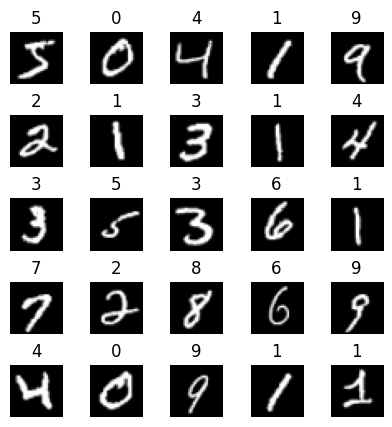

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist_cgan'
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# # where you might want to play around with different loss weights.
# tf.random.set_seed(1234)
# model = ConditionalGAN(n_classes=n_classes)

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# # compatible with saving and loading.
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# model.discriminator.compute_output_shape((None, 32, 32, 1))

In [5]:
latent_dim = 128
n_classes = 10
batch_size = 32

z = tf.random.normal((batch_size, latent_dim))
class_labels = tf.one_hot(tf.random.uniform((batch_size,), 0, n_classes, dtype=tf.int32), depth=n_classes)

model = ConditionalGAN(n_classes=n_classes)
model.compute_output_shape([(None, latent_dim), (None, n_classes)])


Loaded version: vaegan.gan


TensorShape([None, 32, 32, 1])

In [6]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== GENERATOR SUBMODEL ====")
gen_in = tf.keras.layers.Input(model.n_latent_dims+n_classes)
gen_out  = model.generator.call(gen_in) 
gen = tf.keras.Model(gen_in, gen_out) 
gen.summary()
print("=== DISCRIMINATOR SUBMODEL ====")
disc_in = tf.keras.layers.Input(model.image_shape) 
disc_out  = model.discriminator.call(disc_in) 
disc = tf.keras.Model(disc_in, disc_out) 
disc.summary()



=== OVERALL MODEL ====
Model: "cgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator (MultiTaskDi  multiple                  0 (unused)
 scriminator)                                                    
                                                                 
 generator (Generator)       multiple                  1664385   
                                                                 
Total params: 1664391 (6.35 MB)
Trainable params: 1664385 (6.35 MB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________
=== GENERATOR SUBMODEL ====
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 138)]             0         
                                                                 
 dense (Dense)         

## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                 model=model,
                                                 example_labels=labels_onehot[:10],
                                                 n_generated_images=10,
                                                 n_latent_dims=model.n_latent_dims)

## 7. Train (fit) the model on the data 

In [10]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit(x=(data.images_train, labels_onehot),
                  epochs=nEpochs,
                 batch_size=128,
                 callbacks=[save_images_callback])


Epoch 1/20
469/469 [==============================] - 28s 59ms/step - loss_gen: 0.5990 - loss_disc: 1.0281 - top_1_acc: 0.9396
Epoch 2/20
469/469 [==============================] - 28s 59ms/step - loss_gen: 0.5748 - loss_disc: 0.9788 - top_1_acc: 0.9470
Epoch 3/20
469/469 [==============================] - 28s 59ms/step - loss_gen: 0.6656 - loss_disc: 0.9406 - top_1_acc: 0.9532
Epoch 4/20
469/469 [==============================] - 27s 58ms/step - loss_gen: 0.6244 - loss_disc: 0.9142 - top_1_acc: 0.9583
Epoch 5/20
469/469 [==============================] - 28s 59ms/step - loss_gen: 0.6558 - loss_disc: 0.8813 - top_1_acc: 0.9620
Epoch 6/20
469/469 [==============================] - 27s 58ms/step - loss_gen: 0.7712 - loss_disc: 0.8629 - top_1_acc: 0.9656
Epoch 7/20
469/469 [==============================] - 28s 59ms/step - loss_gen: 0.7316 - loss_disc: 0.8362 - top_1_acc: 0.9691
Epoch 8/20
469/469 [==============================] - 27s 58ms/step - loss_gen: 0.6639 - loss_disc: 0.8364 - to

## 8. Training saves results to disk, now also plot training curves

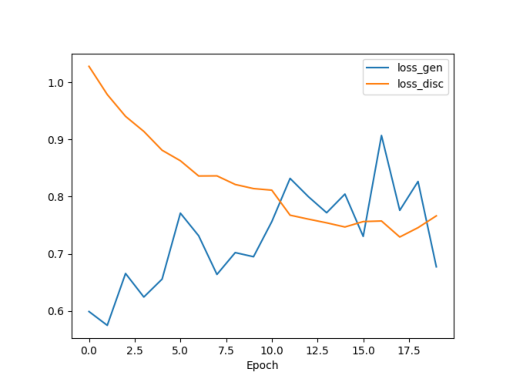

In [6]:
import matplotlib.image as mpimg
img = mpimg.imread('./outputs/mnist_cgan/training_curves.png')  # load image
plt.imshow(img)    # display image
plt.axis('off')    # optional: turn off axis
plt.show()

NameError: name 'logs' is not defined

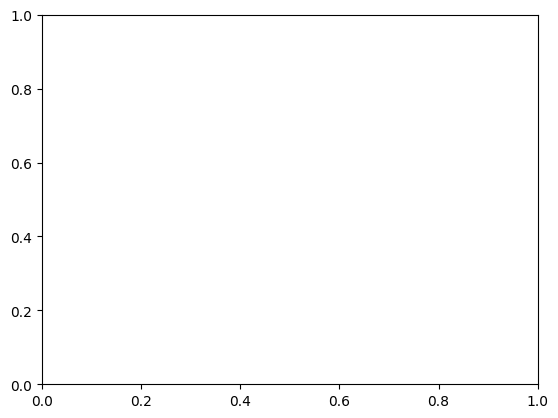

In [3]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['loss_gen', 'loss_disc']:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)
    
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, 'cgan'))


In [11]:
logs.history

{'loss_gen': [3.2747786045074463, 6.511629104614258, 7.469362258911133],
 'loss_disc': [1.0923254489898682, 0.38695642352104187, 0.2682444751262665],
 'acc_class': [0.0, 0.0, 0.0]}